<a href="https://colab.research.google.com/github/PrachitiSParulekar/machine-learning-end-to-end-pipeline/blob/main/SVR_Individual_Household_Electric_Power_Consumption_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
y = individual_household_electric_power_consumption.data.targets

# metadata
print(individual_household_electric_power_consumption.metadata)

# variable information
print(individual_household_electric_power_consumption.variables)

/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

In [3]:
import pandas as pd
import numpy as np
X.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [5]:
X.isnull().sum()

,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,25979


In [6]:
# Convert all numeric columns to float
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    X[col] = pd.to_numeric(X[col], errors='coerce')

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


In [8]:
# Combine date and time into one datetime column
X['datetime'] = pd.to_datetime(X['Date'] + ' ' + X['Time'], format='%d/%m/%Y %H:%M:%S')
X.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [9]:
# Extract hour and weekday/weekend
X['hour'] = X['datetime'].dt.hour
X['day_of_week'] = X['datetime'].dt.dayofweek
X['is_weekend'] = X['day_of_week'] >= 5

In [10]:
X.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,hour,day_of_week,is_weekend
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,17,5,True
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,17,5,True
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,17,5,True
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,17,5,True
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,17,5,True


In [11]:
# Drop rows with missing values
X_clean = X.dropna()
X_clean.shape

(2049280, 13)

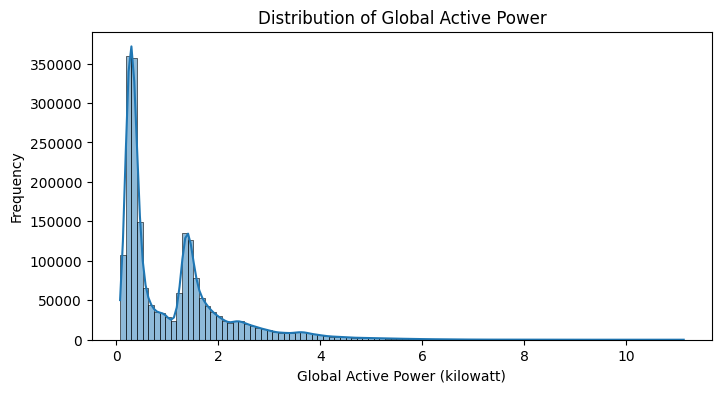

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(X_clean['Global_active_power'], bins=100, kde=True)
plt.title("Distribution of Global Active Power")
plt.xlabel("Global Active Power (kilowatt)")
plt.ylabel("Frequency")
plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler

# Select features for SVR
feature_cols = [
    'Global_intensity', 'Voltage', 'Global_reactive_power',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'hour', 'day_of_week', 'is_weekend'
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean[feature_cols])

y = X_clean['Global_active_power'].values  # Target variable
X_scaled[:5]


array([[ 3.09878851, -1.85181608,  2.61072061, -0.18233673, -0.05127425,
         1.24942076,  0.79363831,  1.00655385,  1.59381575],
       [ 4.13379998, -2.2252745 ,  2.77040557, -0.18233673, -0.05127425,
         1.13089735,  0.79363831,  1.00655385,  1.59381575],
       [ 4.13379998, -2.33021323,  3.32043153, -0.18233673,  0.12048729,
         1.24942076,  0.79363831,  1.00655385,  1.59381575],
       [ 4.13379998, -2.19132373,  3.35591708, -0.18233673, -0.05127425,
         1.24942076,  0.79363831,  1.00655385,  1.59381575],
       [ 2.51378202, -1.59255569,  3.58657312, -0.18233673, -0.05127425,
         1.24942076,  0.79363831,  1.00655385,  1.59381575]])

In [14]:
# Sort by datetime just in case
X_clean_sorted = X_clean.sort_values('datetime')
X_scaled_sorted = scaler.transform(X_clean_sorted[feature_cols])
y_sorted = X_clean_sorted['Global_active_power'].values

n_total = len(X_clean_sorted)
n_train = int(n_total * 0.8)

X_train, X_test = X_scaled_sorted[:n_train], X_scaled_sorted[n_train:]
y_train, y_test = y_sorted[:n_train], y_sorted[n_train:]

print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Train samples: 1639424
Test samples: 409856


In [17]:
from sklearn.svm import SVR
# Use only 50,000 sample points for training and testing
sample_size = 50000
X_train_small = X_train[-sample_size:]
y_train_small = y_train[-sample_size:]
X_test_small = X_test[:sample_size]
y_test_small = y_test[:sample_size]

svr = SVR(kernel='rbf')
svr.fit(X_train_small, y_train_small)

SVR()

In [18]:
y_pred_small = svr.predict(X_test_small)
print("Sample predictions :", y_pred_small[:5])

Sample predictions : [0.51788142 0.51896826 0.53234595 0.49087126 0.51982589]


In [21]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Grid search parameters
param_grid = {
    'C': [0.1,1],             # Just 1 value
    'gamma': ['scale',0.1,1],   # Just 'scale'
    'epsilon': [0.1,0.2],     # Just 1 value
    'kernel': ['rbf']
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Use smaller subset for grid search as previously recommended
svr = SVR()
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train_small, y_train_small)

print("Best SVR params:", grid_search.best_params_)
print("Best score (neg-MSE):", grid_search.best_score_)


Best SVR params: {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score (neg-MSE): -0.020937268306944225


RMSE: 0.006
MAE: 0.045
R²: 0.994


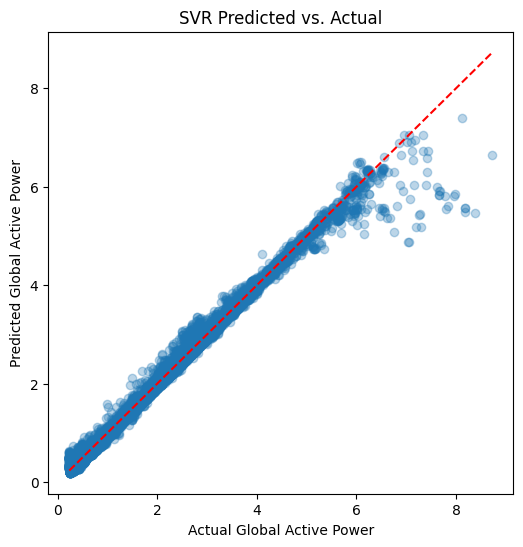

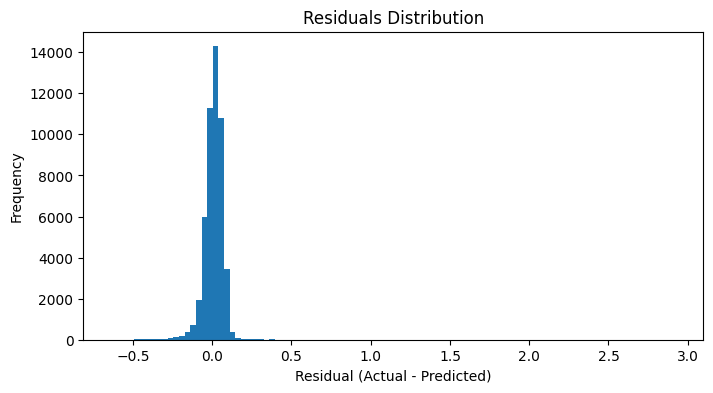

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# y_pred should match what you predicted earlier for your chosen model
# For SVR: y_pred_small; for LinearSVR: y_pred_linear

y_pred = y_pred_small  # Change this if you used LinearSVR

rmse = mean_squared_error(y_test_small, y_pred)
mae = mean_absolute_error(y_test_small, y_pred)
r2 = r2_score(y_test_small, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

# Scatter: Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test_small, y_pred, alpha=0.3)
plt.xlabel('Actual Global Active Power')
plt.ylabel('Predicted Global Active Power')
plt.title('SVR Predicted vs. Actual')
plt.plot([y_test_small.min(), y_test_small.max()], [y_test_small.min(), y_test_small.max()], 'r--')
plt.show()

# Residual plot
residuals = y_test_small - y_pred
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=100)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

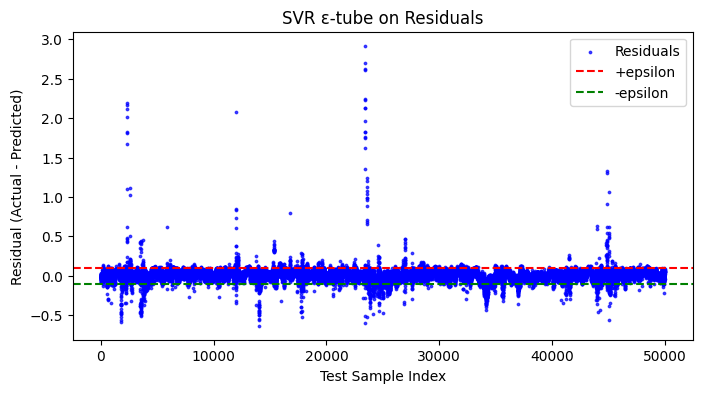

94.47% of test predictions are within the ε-tube (ε = 0.1)


In [24]:
# Use the same epsilon value as your model (e.g., 0.1)
epsilon = 0.1

plt.figure(figsize=(8, 4))
plt.scatter(range(len(residuals)), residuals, s=3, alpha=0.7, label='Residuals', color='blue')
plt.axhline(epsilon, color='red', linestyle='--', label='+epsilon')
plt.axhline(-epsilon, color='green', linestyle='--', label='-epsilon')
plt.title('SVR ε-tube on Residuals')
plt.xlabel('Test Sample Index')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.show()

# Percentage of points within the epsilon-tube
within_tube = np.abs(residuals) <= epsilon
percent_within = np.mean(within_tube) * 100
print(f"{percent_within:.2f}% of test predictions are within the ε-tube (ε = {epsilon})")


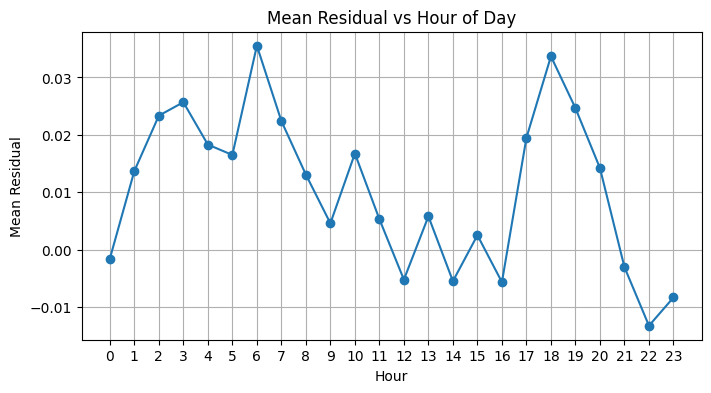

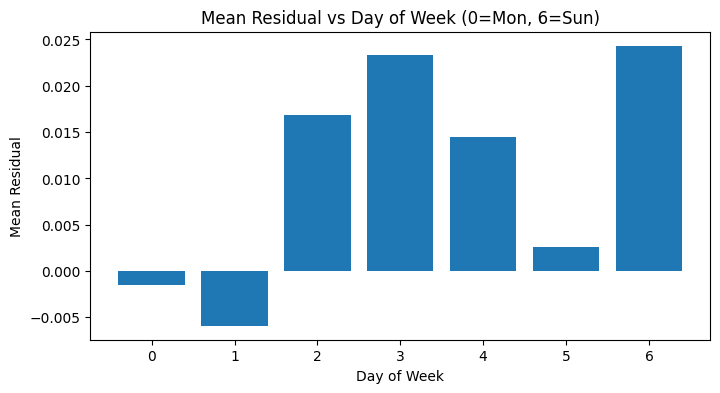

Mean Residual Weekday: 0.009410467830392033
Mean Residual Weekend: 0.01364493221654209


In [25]:
# Attach hour and weekday information to test set residuals
hours_test = X_clean_sorted['hour'].values[-len(y_test_small):]
dayofweek_test = X_clean_sorted['day_of_week'].values[-len(y_test_small):]
is_weekend_test = X_clean_sorted['is_weekend'].values[-len(y_test_small):]

# DataFrame for residual analysis
resid_df = pd.DataFrame({
    'residuals': residuals,
    'hour': hours_test,
    'day_of_week': dayofweek_test,
    'is_weekend': is_weekend_test
})

# Plot mean residual by hour
plt.figure(figsize=(8,4))
hourly_mean = resid_df.groupby('hour')['residuals'].mean()
plt.plot(hourly_mean.index, hourly_mean.values, marker='o')
plt.title("Mean Residual vs Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Mean Residual")
plt.xticks(range(0,24))
plt.grid()
plt.show()

# Plot mean residual by day of week
plt.figure(figsize=(8,4))
dow_mean = resid_df.groupby('day_of_week')['residuals'].mean()
plt.bar(dow_mean.index, dow_mean.values)
plt.title("Mean Residual vs Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Mean Residual")
plt.show()

# Mean residual for weekends vs. weekdays
mean_weekend = resid_df.groupby('is_weekend')['residuals'].mean()
print("Mean Residual Weekday:", mean_weekend[False])
print("Mean Residual Weekend:", mean_weekend[True])

In [26]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 25.3 MB/s eta 0:00:00


<Figure size 800x400 with 0 Axes>

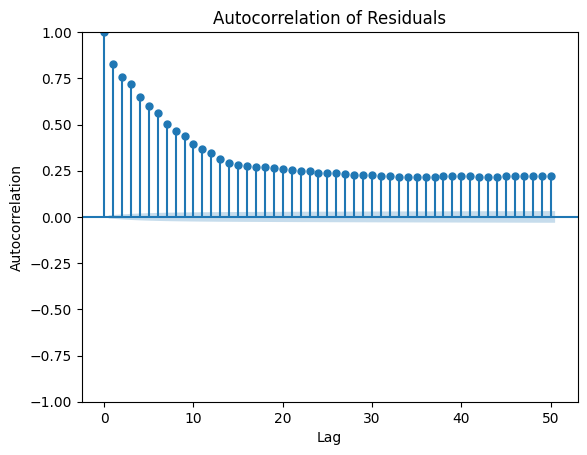

In [27]:
import statsmodels.graphics.tsaplots as tsaplots

plt.figure(figsize=(8,4))
tsaplots.plot_acf(residuals, lags=50)
plt.title("Autocorrelation of Residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()
